<a href="https://colab.research.google.com/github/Paul-antoineLeTolguenec/Machine-Learning/blob/master/seafloorClassification_startercode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>


## Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:
<img src="imgs/screenshot001.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="imgs/screenshot002.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## Fichiers inclus dans le starter code pour cette séance
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
os.chdir('./Machine-Learning')

In [12]:
!git pull

Already up to date.


# Part 0: intro

## 0.1 imports

_Your commented code below_

In [13]:
from pythonTools import *
from usefulCmds import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


None


## 0.2 Examen des données

Écrire des lignes de code permettant:
* de charger les données comprises dans le fichier _labels.csv_,
* de mettre en matrice les descripteurs de l'ensemble de la base d'images
* d'afficher les images avec la fonction _plot\_batch()_ du fichier \_pythonTools.py_,


_Your commented code below_

In [14]:
# Charger le fichier CSV
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)


print("----------------------------------------Data information--------------------------------------------")
#print nombre de données
print("Dimensions du dataset:",dataset_df.shape)

#Nombre de classes:
print(pd.unique(dataset_df['seafloor']).tolist())
#Nombre d'images par classes
print(dataset_df.groupby('seafloor').nunique())

#Ploting batch
print("----------------------------------------Batch--------------------------------------------")
#getting 5 random data
batch=load_batch(dataset_df,5)
print(batch)

----------------------------------------Data information--------------------------------------------
Dimensions du dataset: (360, 2)
['Posidonia', 'Ripple 45°', 'Rock', 'Sand', 'Silt', 'Ripple vertical']
                 id
seafloor           
Posidonia        60
Ripple 45°       60
Ripple vertical  60
Rock             60
Sand             60
Silt             60
----------------------------------------Batch--------------------------------------------
                                 id         seafloor
281             Silt_Sure.02714.png             Silt
354  Ripple vertical_Sure.00489.png  Ripple vertical
333  Ripple vertical_Sure.00201.png  Ripple vertical
33         Posidonia_Sure.00085.png        Posidonia
68        Ripple 45°_Sure.00025.png       Ripple 45°


**Question: Quels sont le nombre de données et le nombre de descripteurs?**

Il y a 360 données. C'est données sont réparties en 6 classes. 
Il y a 60 images par classes.

Il y a 40000 descipteurs par images.(voir plus bas)

Posidonia        60         
Ripple 45°       60         
Ripple vertical  60         
Rock             60     
Sand             60       
Silt             60         

In [15]:
# We add another column to the labels dataset to identify image path
dataset_df['image_path'] = dataset_df.apply( lambda row: (DATASET_PATH + row["id"] ), axis=1)

# Chargement des images
feature_values = np.array([plt.imread(img).reshape(40000,) for img in dataset_df['image_path'].values.tolist()])


## 0.3 prétraitements des labels

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 


_Your commented code below_

In [24]:
import tensorflow as tf
# Récupération des labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

#  transformation des labels selon différents codages
# indices


le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names_unique)

# one-hot-encoding
label_ohe = pd.get_dummies(label_names.reset_index(drop=True)).values

# Getting labels for our dataset
#y = le.transform(label_names)
y = tf.keras.utils.to_categorical(y)


## 0.4 Séparation des données en ensembles 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test


_Your commented code below_

In [25]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(feature_values, y, test_size = 0.25, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(270, 40000) (270, 6) (90, 40000) (90, 6)


<strong>Question:</strong> Pour <ins>chaque ensemble de données</ins> et <ins>pour chaque classe</ins>, quels sont le nombre de données et le nombre de descripteurs? Est-ce important? Pourquoi?

Il y a 75 pourcents des données dans Xtrain et 25 pourcents des données dans Xtest.

X_train= 270 examples

X_test= 90 examples

Pour chaques images il y a 40000 descripteurs (200*200)


_Your commented code below_

In [ ]:
#Lets create a validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_val.shape, y_val.shape)


# Part 1 approches supervisées sur données brutes

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

Il est necessaire de normaliser les descripteurs. En effet de cette façon le modèle converge plus rapidement.On associe à chaque descripteurs la même importance dans la prédiction.

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

**<ins>Question</ins>: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

# Pour la regression logistique regularisée les hyper-paramètres du modèle sont :

-le taux d'apprendtissage

-le paramètre de régularisation

# Pour le réseau de neurones:

-le taux d'apprentissage

-le nombre d'hidden layer

# Pour le random forest:

-la pronfondeur des arbres

-le nombre d'arbres dans la forêt

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

_Your code below_

In [ ]:
#-------------------REGRESSION LOGISTIQUE REGULARISEE---------------------
from linearRegCostFunction import linearRegCostFunction
from trainLinearReg import trainLinearReg
from learningCurve import learningCurve
from polyFeatures import polyFeatures
from featureNormalize import featureNormalize
from plotFit import plotFit
from validationCurve import validationCurve
import numpy as np
from nnCostFunction import nnCostFunction
import scipy.io
from scipy.optimize import minimize, fmin_cg, fmin_l_bfgs_b
import numpy as np
#-------------------NEURAL NETWORK-----




def randInitializeWeights(L_in, L_out):
    E = 0.12
    W = np.random.rand(L_out, 1+L_in) * 2 * E - E
    return W


input_layer_size  = 40000
hidden_layer_size = 25 
num_labels = 6    



print('\n -------------------------- \n')
print('Initializing Neural Network Parameters ...')


initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)


print(initial_theta1.T.ravel().shape)
print(initial_theta2.T.ravel().shape)

initial_nn_params = np.hstack((initial_theta1.T.ravel(), initial_theta2.T.ravel()))


print(initial_nn_params.shape)




 -------------------------- 

Initializing Neural Network Parameters ...
(1000025,)
(156,)
(1000181,)


In [ ]:
print(y_train.shape)

(270,)


In [ ]:
print('\n -------------------------- \n')
print('Training Neural Network... ')

Lambda = 1
costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X_train, y_train, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X_train, y_train, Lambda)[1]

result = fmin_cg(costFunc, fprime=gradFunc, x0=initial_nn_params, maxiter=100, disp=True,full_output=True)

nn_params = result[0]
cost = result[1]
theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T








 -------------------------- 

Training Neural Network... 
         Current function value: 9.487272
         Iterations: 100
         Function evaluations: 159
         Gradient evaluations: 159


In [ ]:
def predictNeuralNetwork(Theta1, Theta2, X):
  """ outputs the predicted label of X given the
  trained weights of a neural network (Theta1, Theta2)
  """
  m, _ = X.shape
  num_labels, _ = Theta2.shape
  probas = sigmoid(Theta2 @ (np.vstack((np.ones((1, m)), sigmoid(Theta1 @ X.T)))))
  p = np.argmax(probas, axis=0).reshape((m, 1))
  return p.flatten()

In [ ]:
m, _ = X_test.shape
Xp = np.column_stack((np.ones((m, 1)), X_test))

y_pred = predictNeuralNetwork(theta1, theta2, Xp)

accuracy = np.mean(np.double(y_pred == y_test.flatten())) * 100
print('Training Set Accuracy: %f\n'% accuracy)

Training Set Accuracy: 42.222222



Normalized confusion matrix
[[0.46666667 0.         0.26666667 0.         0.2        0.06666667]
 [0.23529412 0.11764706 0.         0.         0.47058824 0.17647059]
 [0.1        0.         0.1        0.1        0.3        0.4       ]
 [0.0625     0.         0.25       0.125      0.125      0.4375    ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.25       0.         0.0625     0.         0.0625     0.625     ]]


<AxesSubplot:title={'center':'Matrix Confusion'}, xlabel='Predicted label', ylabel='True label'>

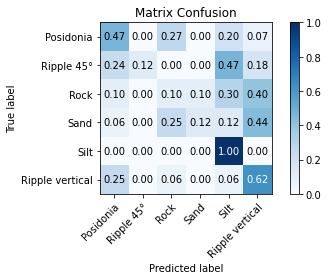

In [ ]:
plot_confusion_matrix(y_test, y_pred, label_names_unique,
                          normalize=True,
                          title="Matrix Confusion",
                          cmap=plt.cm.Blues)

In [20]:
#-------------------NEURAL NETWORK WITH SCIKIT LEARN AND TENSORFLOW---------------------
# Importing libraries
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#Fonction de construction du CNN
def build_classifier(optimizer='adam'):
    # Initialising the CNN
    classifier = Sequential()

    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu',input_dim = 40000))
    classifier.add(Dense(units = 128, activation = 'relu'))
    #classifier.add(Dense(units = 128, activation = 'relu'))

    classifier.add(Dense(units = 6, activation = 'softmax'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

#Instance du classifier
classifier = KerasClassifier(build_fn = build_classifier)

#Liste de paramétres à tester lors de l'entraînement.
parameters = {'batch_size': [50],
              'epochs': [150],
              'optimizer': ['adam']}
#Création de la grille d'entraînement.
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)
#On entraîne avec les différents paramètres spécipfiés dans la liste.
grid_search = grid_search.fit(X_train, y_train,verbose=0)
#On évalue le score et les meilleurs paramétres
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_accuracy,best_parameters)
score = grid_search.score(X_test, y_test)
print(score)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.4 {'batch_size': 50, 'epochs': 150, 'optimizer': 'adam'}
0.4444444444444444


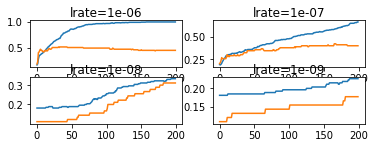

In [27]:
#-------------------------------LEARNING CURVE FOR NEURAL NETWORK ONLY-----------------------------------------------#
from keras.optimizers import Adam
import matplotlib.pyplot as pyplot


def fit_model(trainX, trainy, testX, testy, lrate):
	# define model
	model = Sequential()
	model.add(Dense(120, input_dim=40000, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(6, activation='softmax'))
	# compile model
	opt = Adam(lr=lrate)
	model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
	# plot learning curves
	pyplot.plot(history.history['accuracy'], label='train')
	pyplot.plot(history.history['val_accuracy'], label='test')
	pyplot.title('lrate='+str(lrate), pad=-50)

# create learning curves for different learning rates
learning_rates = [1E-6, 1E-7,1E-8,1E-9]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
pyplot.show()

In [ ]:
#-------------------REGRESSION LOGISTIQUE WITH SCIKIT LEARN ---------------------
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=4)
logreg_cv.fit(X_train,y_train)
#score
best_parameters = logreg_cv.best_params_
best_accuracy = logreg_cv.best_score_
print(best_accuracy,best_parameters)


0.4074846356453029 {'C': 0.1, 'penalty': 'l2'}


In [ ]:
#-------------------RANDOM FOREST WITH SCIKIT LEARN ---------------------

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)
#score
best_parameters = CV_rfc.best_params_
best_accuracy = CV_rfc.best_score_
print(best_accuracy,best_parameters)


0.5592592592592592 {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


In [ ]:
#-------------------SVM WITH SCIKIT LEARN ---------------------
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

param_grid = {'C': [1e3, 1e5],
              'gamma': [0.0001, 0.1], }
clf = GridSearchCV(
    svm.SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train, y_train)
#score
best_parameters = clf.best_params_
best_accuracy = clf.best_score_
print(best_accuracy,best_parameters)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# Use score method to get accuracy of model


0.5962962962962963 {'C': 1000.0, 'gamma': 0.0001}


In [ ]:
#-------------------Neural Network WITH SCIKIT LEARN ---------------------
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

parameters = {'solver': ['lbfgs'], 'max_iter': [100,200 ], 'alpha': 10.0 ** -np.arange(1, 5), 'hidden_layer_sizes':np.arange(10, 12), 'random_state':[0,3,6,9]}
ML = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

ML.fit(X_train, y_train)

#score
best_parameters = ML.best_params_
best_accuracy = ML.best_score_
print(best_accuracy,best_parameters)


**<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

Pour chaques modèle on entraîne sur le jeu de donnée puis on test. 
Pour ce qui est des méthodes d'optimisation des hyper-paramètres, il y a deux méthodes:
-Learning/validation curve 
elle permet de voir l'évolution de la qualité du modèle en fonction de l'entraînement. 
Très utile pour detecter le surentraînement et autre spécificités du modèle.

-Grid search CV 
Permet de croiser tout les hyper-paramètres spécifiés et ressort le modèle avec les meilleurs hyper-paramètres.

# Pour le réseau de neurones avec tensorflow:
J'ai utilisé les deux méthodes 
Le réseau permet d'obtenir une accuracy de 46% sur les données d'entraînement et de 43% sur les données de test.

# Regression logistique:
j'utilise Grid search CV 

hyper-paramètres: Learning rate, C paramètre de régularisation

J'obtiens un score de 41%

# Random forest:
j'utilise Grid search CV 

hyper-paramètres: Profondeur de l'arbre, nombre d'arbres dans la forêt 

J'obtiens un score de 35%

# SVM:
j'utilise Grid search CV 

hyper-paramètres: C paramètre de régularisation, gamma 

J'obtiens un score de 71%

# Neural Network with Sklearn
j'utilise Grid search CV 

hyper-paramètres: Learning rate, nombre d'hiden layer, le solver (algo backpropagation)...

J'obtiens un score de 71%


Le modèle SVM est donc le grand gagnant pour cette classification. 
Ce qui est prévisible car étant donné le jeu de données, c'est celui qui est recommandé par la SKlearn map que l'on peut retrouver sur l'API de la bibliothèque.

**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**

 <img src="graphs.png" />

# Partie 2: Approche supervisée sur descripteurs issus du scattering operator

## Chargement des descripteurs

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

_Your Code below_

In [ ]:
from pythonTools import *
from usefulCmds import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import numpy as np
import pandas as pd
import os

# Loading the csv file
DATASET_PATH = r'./dataset/'
DATASET_FILE = r'./imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat'
DATASET = os.path.join(DATASET_PATH, DATASET_FILE)

DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)

X = np.array([img.reshape(217,) for img in data_mat["featVal"]])


data_mat = loadmat(DATASET)

#On récupère les labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

#  transformation des labels selon différents codages
# indices
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names_unique)
# Getting labels for our dataset
y = le.transform(label_names)


## Prétraitements

**<ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

Oui il faut normaliser les descripteurs car cela permet de réduire le temps d'entraînement. Notamment pour les réseaux de neuronnes. En revanche , il faut garder la taille du vecteur et bien sûr les paramètres de la normalisation. Ces paramètres sont essentielles pour faire une prédiction. En effet, on entraîne le réseau sur un jeu de données normalisé. Il faut garder ces paramètres pour pouvoir présenter au réseau une image dans les même condition lors d'une prédiction ( moyenne , écart-type).

_Your Code below_

In [ ]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


(270, 217) (270,) (90, 217) (90,)


## Apprentissage

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

## Fixer les hyper paramètres

**<ins>Question</ins>: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

Même façon que la partie 1. Lire la partie 1.

Il y a deux possibilités de faire :

Utiliser la learning/validation curve qui permet de visualiser l'erreur du réseau en fonction du nombre d'entraînement.

Utiliser la fonction gridsearch cv bassée sur la cross validation. 


**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

In [ ]:
#-------------------REGRESSION LOGISTIQUE WITH SCIKIT LEARN ---------------------
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=4)
logreg_cv.fit(X_train,y_train)
#score
best_parameters = logreg_cv.best_params_
best_accuracy = logreg_cv.best_score_
print(best_accuracy,best_parameters)


0.9888608428446005 {'C': 1.0, 'penalty': 'l2'}


In [ ]:
#-------------------RANDOM FOREST WITH SCIKIT LEARN ---------------------

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)
#score
best_parameters = CV_rfc.best_params_
best_accuracy = CV_rfc.best_score_
print(best_accuracy,best_parameters)


0.9592592592592593 {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}


In [ ]:
#-------------------SVM WITH SCIKIT LEARN ---------------------
from sklearn import svm
from sklearn.model_selection import cross_val_score

param_grid = {'C': [1e3,1e4, 1e5],
              'gamma': [0.0001,0.001,0.005,0.01,0.05, 0.1], }
clf = GridSearchCV(
    svm.SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train, y_train)
#score
best_parameters = clf.best_params_
best_accuracy = clf.best_score_
print(best_accuracy,best_parameters)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# Use score method to get accuracy of model

0.9925925925925926 {'C': 1000.0, 'gamma': 0.01}


In [ ]:
#-------------------Neural Network WITH SCIKIT LEARN ---------------------
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

parameters = {'solver': ['lbfgs'], 'max_iter': [1000,2000 ], 'alpha': 10.0 ** -np.arange(1, 5), 'hidden_layer_sizes':np.arange(10, 12), 'random_state':[0,3,6,9]}
ML = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

ML.fit(X_train, y_train)

#score
best_parameters = ML.best_params_
best_accuracy = ML.best_score_
print(best_accuracy,best_parameters)


0.9962962962962962 {'alpha': 0.01, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'random_state': 9, 'solver': 'lbfgs'}


**<ins>Question</ins>: Évaluer les résultats et donner la valeur des paramètres optimaux**

# Résultats

## Regression logistique
Best score = 0.9888608428446005

Best parametres : C=1.0, 'penalty=l2

## Random forest
Best score = 0.9592592592592593

Best parametres : criterion = gini, max_depth = 8, max_features = log2, n_estimators = 100

## SVM
Best score = 0.9925925925925926

Best parametres : C = 1000.0, gamma = 0.01

## Neural Network
Best score = 0.9962962962962962

Best parametres : alpha = 0.01, hidden_layer_sizes = 10, max_iter = 1000, random_state = 9, solver = lbfgs


## Apprendre le modèle final pour chaque classifieur

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       0.83      1.00      0.91        10
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        16
           5       0.93      0.88      0.90        16

    accuracy                           0.97        90
   macro avg       0.96      0.97      0.96        90
weighted avg       0.97      0.97      0.97        90


Confusion matrix:
[[15  0  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  0 

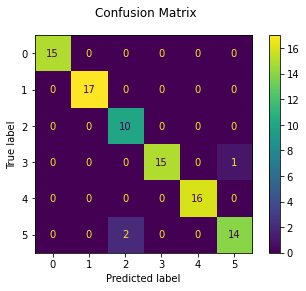

In [ ]:
# Logistic regression
logreg=LogisticRegression(C=1.0, penalty='l2')
logreg.fit(X_train,y_train)
# Now predict the value of the digit on the second half:
predicted = logreg.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (logreg, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(logreg, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        17
           2       0.69      0.90      0.78        10
           3       0.94      0.94      0.94        16
           4       1.00      1.00      1.00        16
           5       0.93      0.81      0.87        16

    accuracy                           0

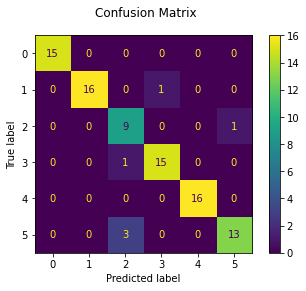

In [ ]:
#Random Forest

rfc=RandomForestClassifier(random_state=42,criterion='gini',max_depth=8, max_features='log2',n_estimators=100)
rfc.fit(X_train,y_train)
# Now predict the value of the digit on the second half:
predicted = rfc.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (rfc, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(rfc, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()


Classification report for classifier SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       0.91      1.00      0.95        10
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        16
           5       0.94      0.94      0.94        16

    accuracy                           0.98        90
   macro avg       0.97      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90


Confusion matrix:
[[15  0  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  0 15  0  1]
 [ 0  0  0  0 16  0]
 [ 0  0  1  0  0 15]]


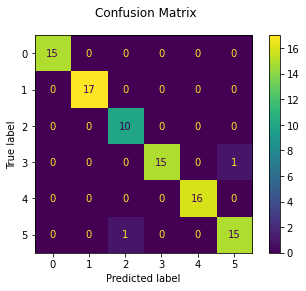

In [ ]:
#SVM

clf=svm.SVC(kernel='rbf', class_weight='balanced',C=1000.0, gamma= 0.01)
clf.fit(X_train,y_train)
# Now predict the value of the digit on the second half:
predicted = clf.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()


Classification report for classifier MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=9, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       0.91      1.00      0.95        10
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        16
           5       0.94      0.94      0.94        16

    accuracy                           0.98        90
   macro 

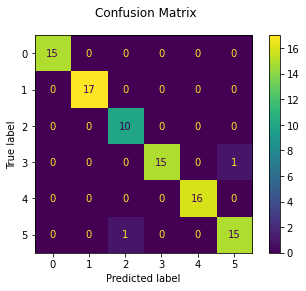

In [ ]:
# Neural network
ML=MLPClassifier(solver='lbfgs',alpha=0.01, hidden_layer_sizes=10, max_iter=1000, random_state=9)
ML.fit(X_train,y_train)
# Now predict the value of the digit on the second half:
predicted = ML.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (ML, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(ML, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()



# Résultats des modèles finaux
Dans cette dernière partie, on a entraîné les différents modèles avec les hyper-paramètres optimaux que nous avions déterminez dans la partie précédente. 
On a pu évaluer ces différents modèles sur le test set. 
On a pu visualiser notamment la matrice de confusion qui permet de visualiser les erreurs qu'à pu commettre le modèle lors de la prédiction des images du test set.

## Regression logistique
Comme on peut le visualiser sur la matrice de confusion le modèle de Regression logistique a fait 3 erreurs sur le test set.

## Random forest
Comme on peut le visualiser sur la matrice de confusion le modèle de Random forest a fait 6 erreurs sur le test set.

## SVM
Comme on peut le visualiser sur la matrice de confusion le modèle SVM a fait 2 erreurs sur le test set.

## Neural Network
Comme on peut le visualiser sur la matrice de confusion le modèle de Machine learning a fait 2 erreurs sur le test set.

## Partie 4 Analyse finale des résultats


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

 <img src="graphs.png" />

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

La synthèse des différents modèles a été réalisée précédement. On s'aperçoit que les modèles les plus performant sont le modèle de neural network et SVM qu'on pouvait prédire grace à la carte proposée par SKlearn.On remarque que le traitement de convolution et de pooling pour les données de la partie 2 a permis aux modèles de converger vers des résultats bien meilleurs qu'à la partie 1.
Ainsi de façon général pour un traitement d'image on retiendra le modèle du neural network avec en amont un traitement de convolution pour l'extraction de features et pooling pour réduire la taille du vecteur d'entrée.